<a href="https://colab.research.google.com/github/marjanaziminezhad/structural_bioinformatics/blob/main/ex03/ex03_7a3m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 03

## Aim of the exercise:

We will learn to:

- use OpenMM to simulate a protein in water
- understand the steps for setting up a simulation

This exercise is based on the official tutorials of [OpenMM](https://github.com/openmm/openmm_workshop_july2023) and [MDAnalysis](https://userguide.mdanalysis.org/stable/examples/quickstart.html).

<img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex03/openmm_logo.png?raw=1" width="50"/>

# OpenMM

OpenMM is a versatile and high-performance toolkit designed for molecular simulation. It stands out due to its unique blend of features, which include extreme flexibility, openness, and exceptional performance, particularly on modern GPUs.

Summary of Contents:
1. **Setup Conda Environment**: Instructions on preparing the necessary computational environment using Conda.
2. **Download Protein File**: Steps to obtain the required protein structure file.
3. **Load a PDB File into OpenMM**: Tutorial on how to import and use a PDB file within OpenMM.
4. **Choose the Force-Field**: Guidance on selecting appropriate force-fields for the simulation.
5. **Solvate the Protein with Water and Ions**: Process of adding water and ions to the protein environment.
6. **Setup System and Integrator**: Instructions on initializing the simulation system and integrator.
7. **Run Local Minimization**: Steps for performing local energy minimization of the system.
8. **Setup Reporting**: How to configure reporting tools for monitoring simulation progress.
9. **Run NVT Equilibration**: Conducting NVT (constant Number, Volume, Temperature) equilibration simulations.
10. **Run NPT Production Molecular Dynamics**: Executing NPT (constant Number, Pressure, Temperature) production simulations.
11. **Basic Analysis**: Introduction to fundamental analysis techniques for simulation data.
12. **How to Use Checkpoints**: Instructions on setting up and utilizing checkpoints for long-term simulations.
13. **Visualization**: Tips and tools for visualizing the simulation results.



## Setup
**First try and change runtime type to GPU!**  
Click "runtime">"change runtime type" and select "GPU" from the "Hardware accelerator" dropdown menu.
CPU works, but it is slower.


In [1]:
if 'google.colab' in str(get_ipython()):
  print('Running on colab')
  !pip install -q condacolab
  import condacolab
  condacolab.install_mambaforge()
  !mamba install -y -c conda-forge openmm

else:
  print('Not running on colab.')
  print('Make sure you create and activate a new conda environment!')

Running on colab
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://git

**Note:** During this step on Colab the kernel will be restarted. This will produce the error message:
"Your session crashed for an unknown reason. " This is normal and you can safely ignore it.

**Note:** Installing the packages will take several minutes!

In [7]:
# check the installation
!python -m openmm.testInstallation


OpenMM Version: 8.1
Git Revision: 43f571d90fc1c882848cbd9b55e097a1775a9075

There are 3 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.29872e-06
Reference vs. CUDA: 6.72289e-06
CPU vs. CUDA: 7.45569e-07

All differences are within tolerance.


## Protein to Study: Villin headpiece


Villin is a popular protein for molecular dynamics studies, and several papers on its folding have been published. Additionally, it has been found that the proximity of three phenylalanines that comprise the hydrophobic core is important for the correct structure.

This is small fast folding protein commonly used as a toy system. Note that this PDB file has been cleaned up and is ready for use in OpenMM. If you try and use a PDB file directly from the protein data bank you may encounter errors. Please look at the [OpenMM FAQs](https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions) and [PDBfixer](https://github.com/openmm/pdbfixer).

![villin](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex03/villin.png?raw=1)
**Figure**. Villin headpiece protein.


In [8]:
if 'google.colab' in str(get_ipython()):
  print('Running on colab')
  !wget https://raw.githubusercontent.com/yerkoescalona/structural_bioinformatics/main/ex03/villin.pdb
else:
  print('Not running on colab.')
  print('You should have villin.pdb in your path!')

Running on colab
--2023-12-05 11:18:55--  https://raw.githubusercontent.com/yerkoescalona/structural_bioinformatics/main/ex03/villin.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39178 (38K) [text/plain]
Saving to: ‘villin.pdb.1’

villin.pdb.1        100%[===================>]  38.26K  --.-KB/s    in 0.01s   

2023-12-05 11:18:55 (3.49 MB/s) - ‘villin.pdb.1’ saved [39178/39178]



## Load the PDB file into OpenMM
<a id="load"></a>

First we need to import OpenMM.
We then then load in the PDB file using the [PDBFile](http://docs.openmm.org/latest/api-python/generated/openmm.app.pdbfile.PDBFile.html#openmm.app.pdbfile.PDBFile) class.

In [9]:
!wget https://files.rcsb.org/download/7A3M.pdb

--2023-12-05 11:19:00--  https://files.rcsb.org/download/7A3M.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.100
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7A3M.pdb.1’

7A3M.pdb.1              [ <=>                ] 129.41K  --.-KB/s    in 0.08s   

2023-12-05 11:19:00 (1.54 MB/s) - ‘7A3M.pdb.1’ saved [132516]



In [12]:
!conda install -c conda-forge pdbfixer
!pdbfixer 7A3M.pdb

Solving environment: \ | / - \ | / - \ | / - \ | / - 
CondaError: KeyboardInterrupt



In [14]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

# load in the pdb file
pdb = PDBFile('output.pdb')

`PDBFile('file_name.pdb')` loads the PDB file from disk and puts the information into a `PDBFile` object which we have assign to the variable `pdb`. The object contains the molecular topology (atom names, residue types, bonds etc) and the atomic positions. These can be accessed as `pdb.topology` and `pdb.positions`. Take a look at the [API documentation](http://docs.openmm.org/latest/api-python/generated/openmm.app.pdbfile.PDBFile.html#openmm.app.pdbfile.PDBFile). All OpenMM classes have documentation available on the Python API reference: http://docs.openmm.org/latest/api-python/.

## Define the force field
<a id="ff"></a>

We need to define the forcefield we want to use. We will use the Amber14 forcefield and the TIP3P-FB water model. You can find out about all the forcefields available by default in OpenMM in the [documentation](http://docs.openmm.org/latest/userguide/application/02_running_sims.html?highlight=forcefield#force-fields).

In [15]:
# Specify the forcefield
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

Force fields are defined by XML files. The line above loads in specified files. You can look at them in the OpenMM source code, e.g. [`amber14/tip3pfb.xml`](https://github.com/openmm/openmm/blob/master/wrappers/python/openmm/app/data/amber14/tip3pfb.xml). It is possible to create your own XML force field file. You can find details in the [user guide](http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#creating-force-fields).

## Solvate
<a id="solvate"></a>

We can use the [`Modeller`](http://docs.openmm.org/latest/userguide/application/03_model_building_editing.html#model-building-and-editing) class to solvate the protein in a waterbox.

In [16]:
# create a Modeller object
modeller = Modeller(pdb.topology, pdb.positions)


# Solvate the protein in a box of water
modeller.addSolvent(forcefield, padding=1.0*nanometer)

This command creates a box that has edges at least 1nm away from the solute and fills it with water molecules. Additionally, it adds in the required number of CL- and Na+ ions to make the system charge neutral. Optionally, you can specify the ion concentration as an argument to [`addSolvent`](http://docs.openmm.org/latest/api-python/generated/openmm.app.modeller.Modeller.html#openmm.app.modeller.Modeller.addSolvent).

Note that the `nanometer` variable is a unit definition that was imported from `openmm.unit`. This is an example of the powerful units tracking and automatic conversion facility built into the OpenMM Python API that makes specifying unit-bearing quantities convenient and less error-prone. We could have equivalently specified `10*angstrom` instead of `1*nanometer` and achieved the same result. You can read more about the units library [here](http://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#units-and-dimensional-analysis).


## Setup system and Integrator
<a id='system'></a>

We now need to combine our molecular topology and the forcefield to create a complete description of the system. This is done using the [`ForceField`](http://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html#forcefield) object’s [`createSystem()`](http://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html#openmm.app.forcefield.ForceField.createSystem) method. We then create the integrator, and combine the integrator and system to create the Simulation object. Finally we set the initial atomic positions.

In [17]:
# Create a system. Here we define some forcefield settings such as the nonbonded method
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)

# Define the integrator. The Langevin integrator is also a thermostat
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

# Create the Simulation
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

The [System](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html#system) is an object than contains the complete mathematical description of the system we want to simulate. It contains four key bits of information:
 - The set of particles in the simulation
 - The forces acting on them
 - Details of any constraints
 - The dimensions of the periodic box

The `integrator` advances the equations of motion. There are a variety of [integrators available in OpenMM](http://docs.openmm.org/latest/api-python/library.html#integrators). We are using the [LangevinMiddleIntegrator](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html#openmm.openmm.LangevinMiddleIntegrator) which performs Langevin dynamics.

The [`Simulation`](http://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation) object manages all the process involved in running a simulation, such as advancing time and writing output.


## Local energy minimization
<a id="minim"></a>

It is a good idea to run local energy minimization at the start of a simulation because the coordinates in starting configuration file might produce very large forces.

Due to how the minimizer is implemented it will not print out information during the run. You will need to be patient and wait for it to complete. This minimization step should take ~1 minute on CPU and a few seconds on GPU.

In [18]:
print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


## Setup reporting
<a id="reporting"></a>

To get output from a simulation you need to add "reporters". We use [`DCDReporter`](http://docs.openmm.org/latest/api-python/generated/openmm.app.dcdreporter.DCDReporter.html) to write the coordinates every 1000 timesteps to 'traj.dcd' and we use [`StateDataReporter`](http://docs.openmm.org/development/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html) to print the timestep, potential energy, temperature, and volume to the screen; and the same to a file called 'md_log.txt'. The Simulation object contains a list of reporters in `simulation.reporters` and we use the append method to add the reporters to it.

In [20]:
# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))


## NVT equilibration
<a id=nvt></a>

We are using a Langevin integrator which means we are simulating in the NVT ensemble. To equilibrate the temperature we just need to run the simulation for a number of timesteps.

In [21]:
print('Running NVT')
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-244895.777924126,255.77383799911695,160.11529393875426
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-244895.777924126,255.77383799911695,160.11529393875426
2000,-238517.67587334476,288.2573009380722,160.11529393875426
2000,-238517.67587334476,288.2573009380722,160.11529393875426
3000,-235797.922455376,295.62097859845306,160.11529393875426
3000,-235797.922455376,295.62097859845306,160.11529393875426
4000,-235783.6910100635,299.5078507144823,160.11529393875426
4000,-235783.6910100635,299.5078507144823,160.11529393875426
5000,-236168.018158501,304.5432306871252,160.11529393875426
5000,-236168.018158501,304.5432306871252,160.11529393875426
6000,-235935.10946709476,302.82592640046056,160.11529393875426
6000,-235935.10946709476,302.82592640046056,160.11529393875426
7000,-235621.000580376,300.7746043452976,160.11529393875426
7000,-235621.000580376,300.7746043452976,1

## NPT production MD
<a id=npt></a>

To run our simulation in the NPT ensemble we need to add in a barostat to control the pressure. We can use [`MonteCarloBarostat`](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.MonteCarloBarostat.html#openmm.openmm.MonteCarloBarostat). The parameters are the pressure (1 bar) and the temperature (300 K). The barostat assumes the simulation is being run at constant temperature, but it does not itself do anything to regulate the temperature. It is therefore critical that you always use it along with a Langevin integrator or Andersen thermostat, and that you specify the same temperature for both the barostat and the integrator or thermostat. Otherwise, you will get incorrect results.

In [22]:
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))

# It is important to call the reinitialize method on the simulation
# otherwise the modifications will not be applied.
simulation.context.reinitialize(preserveState=True)

We then run the simulation for 10000 steps.

In [23]:
print('Running NPT')
simulation.step(10000)

Running NPT
11000,-237978.77241922403,300.3064384315524,151.86184151080676
11000,-237978.77241922403,300.3064384315524,151.86184151080676
12000,-238743.70279490203,297.5245215193082,150.14911378171698
12000,-238743.70279490203,297.5245215193082,150.14911378171698
13000,-238747.58656017762,301.4718562794962,150.051451701935
13000,-238747.58656017762,301.4718562794962,150.051451701935
14000,-238351.317444372,295.8788544720399,150.414679705814
14000,-238351.317444372,295.8788544720399,150.414679705814
15000,-238485.92507848167,297.72926455056273,149.37942147393517
15000,-238485.92507848167,297.72926455056273,149.37942147393517
16000,-238478.87655839766,301.60110086495365,148.92027855460867
16000,-238478.87655839766,301.60110086495365,148.92027855460867
17000,-238678.14202180807,298.96385101208887,149.40148945313427
17000,-238678.14202180807,298.96385101208887,149.40148945313427
18000,-238163.7855791566,295.7349370406046,148.91675866372958
18000,-238163.7855791566,295.7349370406046,148.916

## Analysis
<a id=analysis></a>

We can now do some basic analysis using Python. We will plot the time evolution of the potential energy, temperature, and box volume. Remember that OpenMM itself is primarily an MD engine, for in-depth analysis of your simulations you can use other python packages such as [MDtraj](https://www.mdtraj.org/), or [MDAnalysis](https://www.mdanalysis.org/).


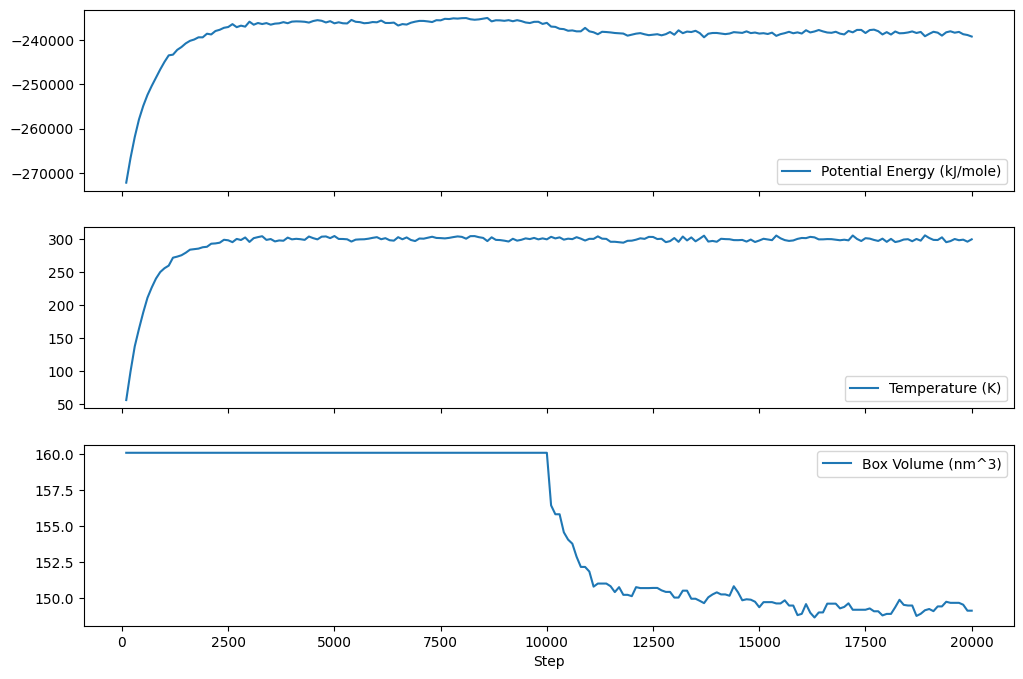

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
md_log_df = pd.read_csv('md_log.txt', delimiter=',', header=0)
md_log_df.rename(columns={'#"Step"': 'Step'}, inplace=True)

fig, ax = plt.subplots(figsize=(12,8), nrows=3, sharex=True)
md_log_df.plot(x='Step', y='Potential Energy (kJ/mole)', ax=ax[0])
md_log_df.plot(x='Step', y='Temperature (K)', ax=ax[1])
md_log_df.plot(x='Step', y='Box Volume (nm^3)', ax=ax[2])
plt.show()

## Checkpointing
<a id=checkpoints></a>

When you run long simulations it is useful to be able to save checkpoints. This means you can restart them in the case of a crash. Or it means you can resume them if you need to fit within the time constraints of a HPC job scheduler.

To run a resume a simulation we need to have three files saved to disk that we can load in:
1. The topology - this will be a PDB file of our solvated system.
2. A serialized `System` -  this is an xml file that contains the forcefield settings.
3. A checkpoint file - this is a binary file that contains the positions, velocities, box vectors, and other internal data such as the states of random number generators.

The first two only need to be saved once because they are constant throughout the simulation. The checkpoint file needs to be saved frequently. You can then resume a simulation from the timestep when the checkpoint file was last saved.


### Setup the checkpoint

We will create the topology file using `PDBFile` to write a PDB file of the system. We will use `XmlSerializer` of save the serialized system to an xml file. And we will use `CheckpointReporter` to regularly create checkpoint files.

In [25]:
# Save the toplogy as a PDB file.
with open('topology.pdb', 'w') as output:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(),output)

# save a serialized version of the system. This stores the forcefield parameters.
with open('system.xml', 'w') as output:
    output.write(XmlSerializer.serialize(system))

# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors. It will save
# a checkpoint every 1000 timesteps.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))


`CheckpointReporter` saves periodic checkpoints of a simulation. The checkpoints will overwrite one another - only the last checkpoint will be saved in the file. Loading a checkpoint will restore a simulation to a reasonably close, but usually not identical, state to when it was written. The checkpoint contains data that is highly specific to the System, Platform, and the hardware and software of the computer it was created on. If you try and load it on a computer with different hardware it is likely to fail. Checkpoints created with different versions of OpenMM are often incompatible.

For a more portable way of saving the state of a simulation you can save the checkpoint as an xml state file. Read the [API docs](http://docs.openmm.org/development/api-python/generated/openmm.app.checkpointreporter.CheckpointReporter.html) for more information.

### Running for a set time limit

We can run for a set amount of wall-clock time using the [`runForClockTime`](http://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation.runForClockTime) method. By [wall-clock](https://en.wikipedia.org/wiki/Elapsed_real_time) time we mean the actual time a program runs for as measured by looking at a clock on a wall (or a watch, or a timer etc) as opposed to the simulated time.


In [26]:
# run for 30 seconds
simulation.runForClockTime(30.0*seconds)

21000,-238865.90402933094,301.19600162212765,148.954999761997
21000,-238865.90402933094,301.19600162212765,148.954999761997
22000,-238831.3886019122,298.62312480258777,148.99341217335325
22000,-238831.3886019122,298.62312480258777,148.99341217335325
23000,-239606.84646588704,303.49738038902535,149.41836103314907
23000,-239606.84646588704,303.49738038902535,149.41836103314907
24000,-238581.53717651335,298.0518454785649,148.65748432755365
24000,-238581.53717651335,298.0518454785649,148.65748432755365
25000,-238927.60941992374,297.6519529961376,148.88167438048015
25000,-238927.60941992374,297.6519529961376,148.88167438048015
26000,-238589.43404278578,303.77497260578866,148.96747737994232
26000,-238589.43404278578,303.77497260578866,148.96747737994232
27000,-238452.6108723248,299.9869892238882,149.43895731476127
27000,-238452.6108723248,299.9869892238882,149.43895731476127
28000,-238340.2036491409,300.4364681928647,149.206674319066
28000,-238340.2036491409,300.4364681928647,149.20667431906

### Resume from a checkpoint

We now have the required files 'topology.pdb', 'system.xml', and 'checkpoint.chk'. We will need to load them in so we can resume the simulation from the last checkpoint. Note that we have to define the integrator again as well as the simulation reporters. Furthermore, we have set the `append=True` flag to the DCD and StateData reporters.

You will need to add a line of code to make the simulation run for 30 seconds of wall time.

In [27]:
pdb = PDBFile('topology.pdb')

with open('system.xml') as input:
    system = XmlSerializer.deserialize(input.read())

# Define the integrator.
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(pdb.topology, system, integrator)

# set the positions, velocities, and box vectors from the checkpoint file
simulation.loadCheckpoint('checkpoint.chk')

# We still need to define the reporters again

# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))


# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))


# write the code to run for 30 seconds of wall clock time
simulation.runForClockTime(30.0*seconds)



#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
53000,-238485.95029412047,306.86736060099577,148.96523355546725
54000,-238681.05400034878,302.42332450926244,149.86815610457086
55000,-238729.51287989435,301.1305708071223,148.79506078705901
56000,-238427.9872854345,305.6083716271634,149.63121660642585
57000,-238188.0337260717,296.52767913740377,149.17655727741104
58000,-238304.55945965834,300.1649773066536,149.12243944298666
59000,-238378.56257807184,302.0460694607318,149.3688966294368
60000,-239102.1739051412,298.53909777247486,149.56706389309213
61000,-238607.95972581743,298.7507497236722,149.37327423712992
62000,-238408.80302362167,300.916674491137,149.54909841982672
63000,-238926.1149588055,303.36061366832496,149.77697937765126
64000,-239271.2767820477,300.1522222953016,148.59710193406596
65000,-238882.4946182305,306.8698275327517,149.84280746412273
66000,-238767.79281914118,299.4687809900526,149.43877355832038
67000,-238350.82644285797,302.618673241949,149

### Resume multiple times

We can practice resuming multiple times. This is something you might have to do to fit a long simulation within the limits of a HPC job scheduler.

You will need to add the code to create the `Simulation` object.

In [28]:
for i in range(3):
    print("Resuming from checkpoint iteration = ", i)

    pdb = PDBFile('topology.pdb')

    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())

    # Define the integrator.
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

    # Create the Simulation
    # write the code to create the simulation object
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')

    # We still need to define the reporters again

    # Write trajectory to a file called traj.dcd every 1000 steps
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

    # Print state information to the screen every 1000 steps
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
            potentialEnergy=True, temperature=True, volume=True))

    # Print the same info to a log file every 100 steps
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))

    # Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))


    # run for 30 seconds
    simulation.runForClockTime(30.0*seconds)


Resuming from checkpoint iteration =  0
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
86000,-239082.4003165681,303.3664166411102,149.3156876208465
87000,-238695.4075748229,301.43152841439746,149.4559811156168
88000,-239287.9315422487,297.8155469781414,148.9693624952061
89000,-238939.6372025893,301.64339523750874,148.60719039191568
90000,-238205.2384972833,303.93920127704985,149.8624685841485
91000,-238228.64725217945,302.55464859405225,148.40089339351456
92000,-238628.9197997162,299.50659562624423,147.99282449851117
93000,-238998.79090537457,301.41724096857786,148.79128874397355
94000,-237562.41424763622,298.0437747609485,149.27083203303775
95000,-238795.64399162447,300.0160339478547,150.01545059398302
96000,-238259.47827717243,297.93973042139805,149.62353448854822
97000,-239110.19897026126,298.9364861153412,149.76383728240137
98000,-238595.82057086518,301.25097172763867,149.96643286102056
99000,-238923.93716023746,299.37969644492875,149.7955405877601
10000

### Analysis

we can redo the analysis on the longer trajectory.

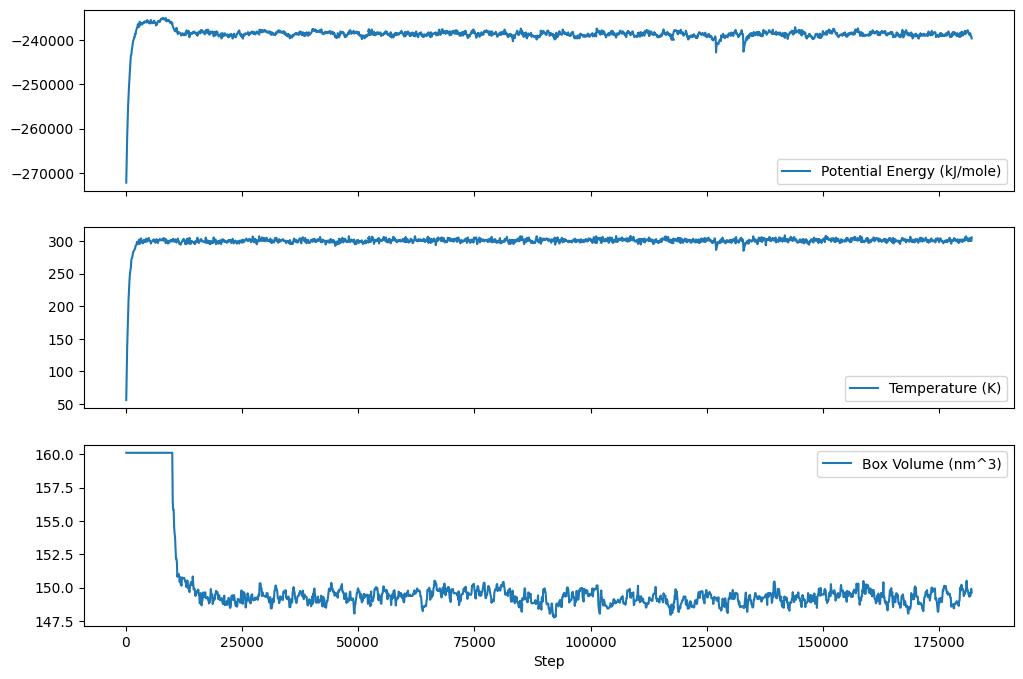

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
md_log_df = pd.read_csv('md_log.txt', delimiter=',', header=0)
md_log_df.rename(columns={'#"Step"': 'Step'}, inplace=True)

fig, ax = plt.subplots(figsize=(12,8), nrows=3, sharex=True)
md_log_df.plot(x='Step', y='Potential Energy (kJ/mole)', ax=ax[0])
md_log_df.plot(x='Step', y='Temperature (K)', ax=ax[1])
md_log_df.plot(x='Step', y='Box Volume (nm^3)', ax=ax[2])
plt.show()

## Visualization
<a id="viz"></a>

We can use the `nglview` package to view the simulation structures and trajectories in the juyter notebook.

For more serious visualization and rendering there a variety of programs available (https://en.wikipedia.org/wiki/List_of_molecular_graphics_systems). A couple of the most popular ones are:
- [VMD](https://www.ks.uiuc.edu/Research/vmd/)
- [PyMol](https://pymol.org/)

**Note this does not currently work in Colab**

In [30]:
if 'google.colab' in str(get_ipython()):
    # https://github.com/googlecolab/colabtools/issues/3409
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mamba install -y -c conda-forge nglview mdtraj


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['nglview', 'mdtraj']

conda-forge/linux-64                                        Using cache
conda

In [31]:
import mdtraj
import nglview

traj = mdtraj.load("traj.dcd", top="topology.pdb")
view = nglview.show_mdtraj(traj)
view.add_representation('licorice',selection="water")
view

NGLWidget(max_frame=233)

**Optional**
1. Download the files "topology.pdb" and "traj.dcd" from Colab.
2. Install [VMD](https://www.ks.uiuc.edu/Research/vmd/).
3. Open "topology.pdb" with VMD or another program of your choice. In VMD you can then go "file">"load data into molecule" and select "traj.dcd".

# MDAnalysis

[MDAnalysis](https://www.mdanalysis.org/) is a Python library for analyzing molecular dynamics (MD) simulations. It supports various MD formats for reading and writing trajectories and atom selections. Key features include reading particle-based trajectories, accessing atomic coordinates via NumPy arrays, powerful atom selection commands, and the ability to manipulate and write out trajectories. This makes it a flexible and efficient tool for complex MD analysis tasks.


In [32]:
if 'google.colab' in str(get_ipython()):
    # https://github.com/googlecolab/colabtools/issues/3409
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mamba install -y -c conda-forge mdanalysis


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['mdanalysis']

conda-forge/linux-64                                        Using cache
conda-forge/

In [33]:
import MDAnalysis as mda

MDAnalysis is a Python package for accessing and analyzing molecular dynamics trajectory data. Its core data structures include:

- **Atom**: Represents a particle, even if it's a coarse-grained bead.
- **AtomGroup**: A crucial class where atoms are grouped. Most data can be accessed through AtomGroups.
- **Universe**: Combines all particles in an AtomGroup with a trajectory, providing access to the entire molecular system.

Working with MDAnalysis typically starts with loading data into a `Universe`.

In [34]:
# loading a trajectory
u = mda.Universe("topology.pdb", "traj.dcd")
u

/usr/local/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<Universe with 15060 atoms>

The trajectory of the simulation is saved in the `u.trajectory` attribute. It is an iterator that yields a `Timestep` object for each frame in the trajectory. The `Timestep` object contains the coordinates of all atoms in the simulation at a given time step. The `Timestep` object also contains the simulation box dimensions, the simulation time, and the simulation step.

In [35]:
# Get the number of frames in the trajectory
len(u.trajectory)

234

Get the number of residues and atoms in the protein

In [36]:
u.residues, u.atoms

(<ResidueGroup with 4731 residues>, <AtomGroup with 15060 atoms>)

MDAnalysis has powerful selection tools that allow you to select atoms based on their properties. For example:

In [37]:
# Select the first 5 residues of the protein
print(u.select_atoms("resid 1:5").residues)
# Select the residues that are within 5 angstroms of the first residue
print(u.select_atoms("around 5 resid 1").residues)
# Selec the PHE residues
print(u.select_atoms("resname PHE").residues)

<ResidueGroup [<Residue MET, 1>, <Residue LYS, 2>, <Residue THR, 3>, ..., <Residue HOH, 3>, <Residue HOH, 4>, <Residue HOH, 5>]>
<ResidueGroup [<Residue LYS, 2>, <Residue THR, 3>, <Residue ASP, 23>, ..., <Residue HOH, 2995>, <Residue HOH, 2998>, <Residue HOH, 3002>]>
<ResidueGroup [<Residue PHE, 50>]>


For the `Universe` object, water molecules are considered as residues. To select only the protein, you can use the `protein` keyword.

In [38]:
# Select the protein
protein = u.select_atoms("protein")

In [39]:
type(protein)

MDAnalysis.core.groups.AtomGroup

`AtomGroups` are the core data structure in MDAnalysis. You can get the positions of the atoms in an `AtomGroup` as a numpy array, as well as other properties such as the atom names, residue names, residue numbers, and residue IDs.

In [40]:
protein.positions

array([[31.399433  , 14.116243  ,  2.4868486 ],
       [30.584843  , 13.858711  ,  3.0255697 ],
       [32.150547  , 13.613117  ,  2.9371734 ],
       ...,
       [31.412521  , 29.454145  ,  0.39329332],
       [30.905735  , 29.842888  ,  1.4274548 ],
       [32.22317   , 30.124762  , -0.27680117]], dtype=float32)

In [41]:
print("Center of Mass:", protein.center_of_mass())
print("Center of Geometry:", protein.center_of_geometry())
print("Total Mass:", protein.total_mass())
print("Radius of Gyration:", protein.radius_of_gyration())

Center of Mass: [25.5264234  28.07135304  7.37179391]
Center of Geometry: [25.48517068 28.13865981  7.43804661]
Total Mass: 7289.63
Radius of Gyration: 11.557276136946253


## Working with trajectories

The trajectory of a Universe contains the changing coordinate information.
The standard way to assess the information of each frame in a trajectory is to iterate over it. When the timestep changes, the universe only contains information associated with that timestep.



In [42]:
for ts in u.trajectory:
    time = u.trajectory.time
    rgyr = protein.radius_of_gyration()
    print(f"Frame: {ts.frame:3d}, Time: {time:4.0f} ps, Rgyr: {rgyr:.4f} A")

Frame:   0, Time:    2 ps, Rgyr: 11.5573 A
Frame:   1, Time:    4 ps, Rgyr: 11.5573 A
Frame:   2, Time:    6 ps, Rgyr: 11.6472 A
Frame:   3, Time:    8 ps, Rgyr: 11.6472 A
Frame:   4, Time:   10 ps, Rgyr: 11.5210 A
Frame:   5, Time:   12 ps, Rgyr: 11.5210 A
Frame:   6, Time:   14 ps, Rgyr: 11.5805 A
Frame:   7, Time:   16 ps, Rgyr: 11.5805 A
Frame:   8, Time:   18 ps, Rgyr: 11.4514 A
Frame:   9, Time:   20 ps, Rgyr: 11.4514 A
Frame:  10, Time:   22 ps, Rgyr: 11.4115 A
Frame:  11, Time:   24 ps, Rgyr: 11.4115 A
Frame:  12, Time:   26 ps, Rgyr: 11.4399 A
Frame:  13, Time:   28 ps, Rgyr: 11.4399 A
Frame:  14, Time:   30 ps, Rgyr: 11.4750 A
Frame:  15, Time:   32 ps, Rgyr: 11.4750 A
Frame:  16, Time:   34 ps, Rgyr: 11.4256 A
Frame:  17, Time:   36 ps, Rgyr: 11.4256 A
Frame:  18, Time:   38 ps, Rgyr: 11.3416 A
Frame:  19, Time:   40 ps, Rgyr: 11.3416 A
Frame:  20, Time:   42 ps, Rgyr: 11.3720 A
Frame:  21, Time:   44 ps, Rgyr: 11.3720 A
Frame:  22, Time:   46 ps, Rgyr: 11.3371 A
Frame:  23,

In order to collect the radius of gyration, we can iterate over the trajectory and store the information in a list.
This can then be converted into other data structures, such as a numpy array or a pandas DataFrame. It can be plotted (as below), or used for further analysis.

In [43]:
import pandas as pd

rgyr = []
time = []
protein = u.select_atoms("protein")
for ts in u.trajectory:
    time.append(u.trajectory.time)
    rgyr.append(protein.radius_of_gyration())

rgyr_df = pd.DataFrame(rgyr, columns=['Radius of gyration (A)'], index=time)
rgyr_df.index.name = 'Time (ps)'
rgyr_df

,Radius of gyration (A)
Time (ps),
2.000000,11.557276
4.000000,11.557276
6.000000,11.647166
8.000000,11.647166
10.000000,11.521046
...,...
460.000001,11.397359
462.000001,11.479914
464.000001,11.402770


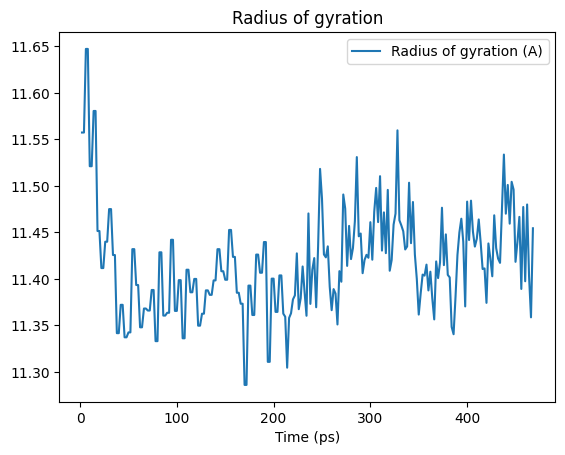

In [44]:
rgyr_df.plot(title='Radius of gyration')
plt.show()

RMSD is a common metric for assessing the similarity of two structures.

In [45]:
from MDAnalysis.analysis import rms

bb = u.select_atoms('backbone')

u.trajectory[0] # first frame
first = bb.positions

u.trajectory[-1] #last frame
last = bb.positions

rms.rmsd(first, last)

2.3559421870196835

In the trajectory analysis, we can calculate the RMSD of each frame to the first frame.

In [46]:
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()

In [47]:
rmsd_analysis.results.rmsd.shape

(234, 5)

We can interpret this as an array with 30 rows and 5 columns. Each row is the RMSD associated with a frame in the trajectory. The columns are as follows:

1. Frame number
2. Time (ps)
3. RMSD (backbone)
4. RMSD (C-alpha)
5. RMSD (protein)

In [48]:
import pandas as pd

rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 2:],
                       columns=['Backbone', 'C-alphas', 'Protein'],
                       index=rmsd_analysis.results.rmsd[:, 1])
rmsd_df.index.name = 'Time (ps)'
rmsd_df.head()

,Backbone,C-alphas,Protein
Time (ps),,,
2.0,1.685874e-07,1.349004e-07,1.363926e-07
4.0,1.685874e-07,1.349004e-07,1.363926e-07
6.0,5.186100e-01,4.967250e-01,7.965299e-01
8.0,5.186100e-01,4.967250e-01,7.965299e-01
10.0,6.390970e-01,6.149611e-01,9.126192e-01


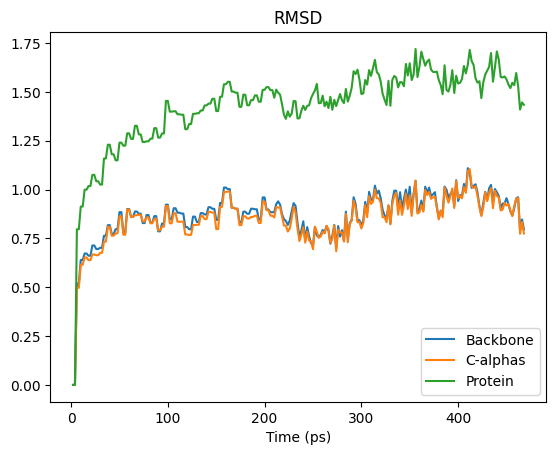

In [49]:
rmsd_df.plot(title='RMSD')
plt.show()

# Exercises

1. Extend the simulation, running 3 more iterations (See `Resume multiple times` subsubsection).
2. Use MDAnalysis to calculate the radius of gyration and RMSD of the protein for each frame in the trajectory. Plot the radius of gyration as a function of time.
3. Plot the RMSD of the backbone and the Total Energy of the simulation as a function of time (use subplots). Are they correlated? Why or why not?
4. Use MDAnalysis to calculate the distances between sidechains of the three phenylalanines that comprise the hydrophobic core. Plot the distances as a function of time. Is the hydrophobic core stable? Why or why not?


Resuming from checkpoint iteration = 0
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
183000,-238330.98132006498,302.59908404193743,149.88594602839336
184000,-238425.92755583557,298.8418163192559,150.1828526962975
185000,-237360.07914864924,298.44659011889865,149.6155002329971
186000,-238305.07306644367,301.51157449340917,149.82229894461796
187000,-238073.41635407158,300.4617945437105,149.47998370527714
188000,-238299.7444906761,302.27517089152906,149.08755632046407
189000,-239289.46221144707,297.4345090829982,148.8926086593075
190000,-238712.34823127114,300.2212705512966,149.48715865121153
191000,-238791.80440167105,298.6107029491245,149.6822547819093
192000,-238645.21507219668,301.42590995272246,149.59444340945242
193000,-238676.98687453568,300.64026353358787,148.76290931311124
194000,-237700.63470996055,299.4799024211672,149.30381453325484
195000,-238524.26043977635,302.89710783509724,148.485660901641
196000,-239003.5604352015,301.2049350266596,148.808522

/usr/local/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
215000,-238649.03042213898,300.28976532253193,149.2576481286019
216000,-238434.8712997106,301.4207665608413,148.48123850820264
217000,-238022.51187386923,299.1570317979468,149.06638827059626
218000,-237698.82809304772,299.35576978817846,149.35556618932122
219000,-238349.09068272752,300.7628452409576,148.44828686033173
220000,-238450.65386413876,303.2712951386476,148.8004189207928
221000,-238792.28602332878,301.5528477931403,148.71013328533135
222000,-238902.62914323807,298.3189651783492,148.91192312897869
223000,-238762.46553114243,306.543862526045,149.1244848184168
224000,-238612.76879009,297.6574895862496,149.0219512546055
225000,-239228.98823253787,302.0743870257244,148.7111636692117
226000,-238171.94106037798,300.1760985302878,148.99282568889265
227000,-238423.91169904405,302.73517661023027,148.81567444414912
228000,-238966.39099992765,301.91447164132654,148.75662619466917
229000,-238405.38547256542,300.0653

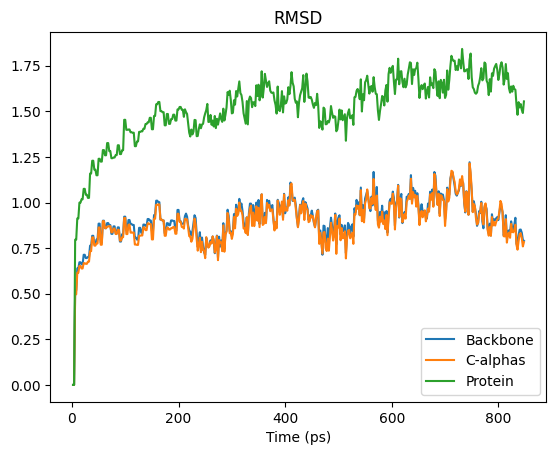

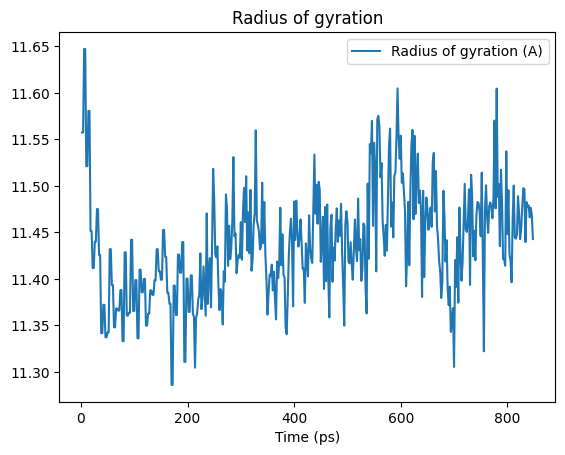

<Figure size 640x480 with 0 Axes>

In [50]:
from simtk.openmm import LangevinMiddleIntegrator, XmlSerializer
from simtk.openmm.app import PDBFile, DCDReporter, StateDataReporter, CheckpointReporter, Simulation
from simtk.unit import kelvin, picosecond, picoseconds, seconds
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.analysis import rms

# Number of iterations
num_iterations = 6

# Lists to store data for plotting
rgyr_data = []
rmsd_backbone_data = []
time_data = []

for i in range(num_iterations):
    print("Resuming from checkpoint iteration =", i)

    pdb = PDBFile('topology.pdb')

    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())

    # Define the integrator.
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

    # Create the Simulation
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')

    # Define reporters
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
            potentialEnergy=True, temperature=True, volume=True))
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

    # Run for 30 seconds
    simulation.runForClockTime(30.0*seconds)

    # Analyze using MDAnalysis
    u = mda.Universe('topology.pdb', 'traj.dcd')

    # Calculate radius of gyration
    rgyr_data.append(u.select_atoms('protein').radius_of_gyration())


    # Calculate RMSD of backbone
    bb = u.select_atoms('backbone')
    first_frame = bb.positions
    u.trajectory[-1]  # last frame
    last_frame = bb.positions
    rmsd_backbone_data.append(rms.rmsd(first_frame, last_frame))

    # Store time data
time_data.append([ts.time for ts in u.trajectory])
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()
rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 2:],
                       columns=['Backbone', 'C-alphas', 'Protein'],
                       index=rmsd_analysis.results.rmsd[:, 1])
rmsd_df.index.name = 'Time (ps)'
rmsd_df.head()
# Plotting radius of gyration
rmsd_df.plot(title='RMSD')
plt.show()
rgyr = []
time = []
protein = u.select_atoms("protein")
for ts in u.trajectory:
    time.append(u.trajectory.time)
    rgyr.append(protein.radius_of_gyration())
rgyr_df = pd.DataFrame(rgyr, columns=['Radius of gyration (A)'], index=time)
rgyr_df.index.name = 'Time (ps)'
rgyr_df
rgyr_df.plot(title='Radius of gyration')
plt.show()
plt.tight_layout()
plt.show()


In [52]:
from MDAnalysis.analysis import rms

bb = u.select_atoms('backbone')

u.trajectory[0] # first frame
first = bb.positions

u.trajectory[-1] #last frame
last = bb.positions

rms.rmsd(first, last)

3.893565517388686

In [53]:
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()

In [54]:
rmsd_analysis.results.rmsd.shape


(424, 5)

In [55]:
import pandas as pd

rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 2:],
                       columns=['Backbone', 'C-alphas', 'Protein'],
                       index=rmsd_analysis.results.rmsd[:, 1])
rmsd_df.index.name = 'Time (ps)'
rmsd_df.head()

,Backbone,C-alphas,Protein
Time (ps),,,
2.0,1.685874e-07,1.349004e-07,1.363926e-07
4.0,1.685874e-07,1.349004e-07,1.363926e-07
6.0,5.186100e-01,4.967250e-01,7.965299e-01
8.0,5.186100e-01,4.967250e-01,7.965299e-01
10.0,6.390970e-01,6.149611e-01,9.126192e-01


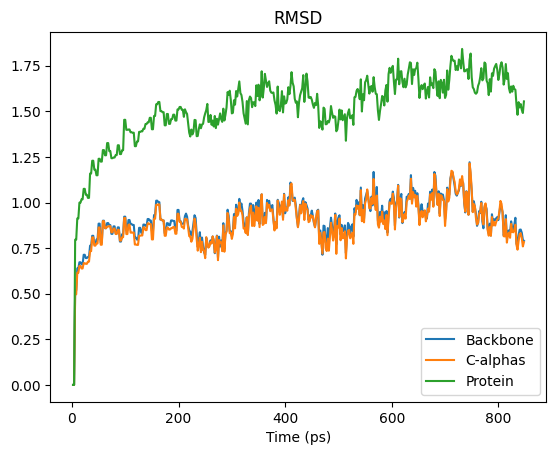

In [56]:
rmsd_df.plot(title='RMSD')
plt.show()

# For the project

This could take plenty of time, so please, start early!.

1. Use OpenMM to run a simulation of your protein of interest.
2. **OPTIONAL** Execute the simulation until observe a stable RMSD and Total Energy. In real life experiments, you will need to run the simulation for a long time.  
3. Use MDAnalysis to analyze the trajectory. Calculate the RMSD of the backbone and the Total Energy of the simulation as a function of time.
4. Compare the last snapshot of the trajectory with the initial structure and the one predicted by Alphafold. Are they similar? Why or why not?

The first step could be complicated. Most of the PDBs contain water and ions.
You need to remove them before you can use the PDB file in OpenMM.
You can use [PDBfixer](https://github.com/openmm/pdbfixer).

In [ ]:
if 'google.colab' in str(get_ipython()):
    # https://github.com/googlecolab/colabtools/issues/3409
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mamba install -y -c conda-forge pdbfixer


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pdbfixer']

conda-forge/linux-64                                        Using cache
conda-forge/no

For example, to create the villin.pdb file used in this tutorial, you need to execute the following code:

In [ ]:
!pdbfixer YOURPROTEIN.pdb

Traceback (most recent call last):
  File "/usr/local/bin/pdbfixer", line 10, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/site-packages/pdbfixer/pdbfixer.py", line 1262, in main
    fixer = PDBFixer(filename=sys.argv[1])
  File "/usr/local/lib/python3.10/site-packages/pdbfixer/pdbfixer.py", line 243, in __init__
    file = open(filename, 'r')
FileNotFoundError: [Errno 2] No such file or directory: 'YOURPROTEIN.pdb'


You can also execute pdbfixer and it will pop up a web interface.